This code is used to reformat the data quoted from various papers, 
then compare the pulsar positions from timing and VLBI astrometry.

The VLBI positions are provided in the PSRPI and MSPSRPI project.

This notebook is organized by the same logic way as `timing-vs-gaiaedr3-position-comparison-with-true-match`, so that I will not explain any more.

In [1]:
from functools import reduce

import numpy as np
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
from astropy.time import Time
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import NullLocator
from numpy import concatenate, cos, pi, sin, sqrt
from scipy.optimize import curve_fit
from statsmodels.iolib.table import SimpleTable

from psrcrf_tools import *

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

## 1.1 Load the database

Read the timing solution data.

In [2]:
timing_table = Table.read(
    "../data/timing_vlbi.fits",
)
timing_table.sort("psr_name")

Add unit information

In [3]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [4]:
vlbi_table = Table.read("../data/psrpi.dat", format="ascii")

Add unit information

In [5]:
vlbi_table["ra"].unit = u.deg
vlbi_table["dec"].unit = u.deg
vlbi_table["pmra"].unit = u.mas / u.yr
vlbi_table["pmdec"].unit = u.mas / u.yr
vlbi_table["plx"].unit = u.mas
vlbi_table["ra_err"].unit = u.mas
vlbi_table["dec_err"].unit = u.mas
vlbi_table["pmra_err"].unit = u.mas / u.yr
vlbi_table["pmdec_err"].unit = u.mas / u.yr
vlbi_table["plx_err"].unit = u.mas

Supplement the timing table with the VLBI astrometric information.

In [6]:
vlbi_timing = join(
    timing_table, vlbi_table, keys="psr_name", join_type="left", table_names=["t", "v"]
)

vlbi_timing.rename_column("pos_epoch_t", "pos_epoch")

count_psr_nb(vlbi_timing)

There are 62 pulsars with 221 measurements.


## 1.2 Compute position offset

Propagate the VLBI position from its epoch to the timing positonal epoch and compute the positional offset,
in the sense of timing minus VLBI.

In [7]:
# Epoch difference in Julian year
dt_y = (vlbi_timing["pos_epoch"].value -
        vlbi_timing["pos_epoch_v"]) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(vlbi_timing["dec_v"].value))

dra = (
    vlbi_timing["ra_t"] - vlbi_timing["ra_v"]
) * dec_fac - dt_y * vlbi_timing["pmra_v"]

ddec = vlbi_timing["dec_t"] - vlbi_timing["dec_v"] - \
    dt_y * vlbi_timing["pmdec_v"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

vlbi_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [8]:
vlbi_timing["ra_err_t"] = vlbi_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    vlbi_timing["ra_err_v"] ** 2
    + vlbi_timing["ra_err_t"] ** 2
    + (dt_y * vlbi_timing["pmra_err_v"]).value ** 2
)

ddec_err = np.sqrt(
    vlbi_timing["dec_err_v"] ** 2
    + vlbi_timing["dec_err_t"] ** 2
    + (dt_y * vlbi_timing["pmdec_err_v"]).value ** 2
)

vlbi_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

## 1.3 Plot sky distribution of the pulsar sample

In [9]:
mask = vlbi_timing["eph"] == "DE200"
vlbi_timing200 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE405"
vlbi_timing405 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE421"
vlbi_timing421 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE430"
vlbi_timing430 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE436"
vlbi_timing436 = vlbi_timing[mask]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


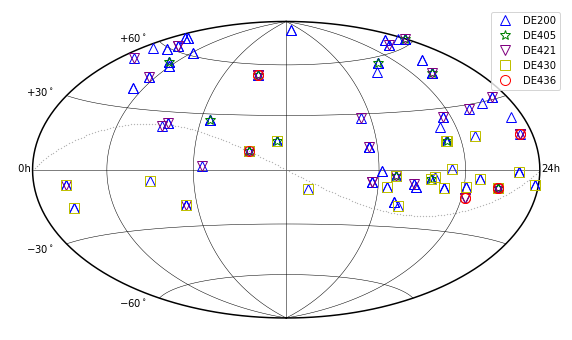

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(vlbi_timing200["ra_v"], vlbi_timing200["dec_v"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(vlbi_timing405["ra_v"], vlbi_timing405["dec_v"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(vlbi_timing421["ra_v"], vlbi_timing421["dec_v"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(vlbi_timing430["ra_v"], vlbi_timing430["dec_v"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(vlbi_timing436["ra_v"], vlbi_timing436["dec_v"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

plt.savefig("../plots/vlbi_psr.eps", dpi=100)

## 1.4 Compute statistics of positional formal uncertainties

In [11]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(vlbi_timing200, ref="v")
pos_err_tab[1, :] = calc_med_pos_err(vlbi_timing405, ref="v")
pos_err_tab[2, :] = calc_med_pos_err(vlbi_timing421, ref="v")
pos_err_tab[3, :] = calc_med_pos_err(vlbi_timing430, ref="v")
pos_err_tab[4, :] = calc_med_pos_err(vlbi_timing436, ref="v")

# 2. Comparison of pulsar positions from timing and VLBI

##  2.1 DE200 vs VLBI

In [12]:
mask = vlbi_timing["eph"] == "DE200"
vlbi_timing200 = vlbi_timing[mask]

nb_psr_200 = len(vlbi_timing200.group_by("psr_name").groups)
nb_obs_200 = len(vlbi_timing200)

print("We have", nb_psr_200,
      "pulsars in the sample from DE200 vs. PSRPI comparison with",
      nb_obs_200, "observations.")

We have 61 pulsars in the sample from DE200 vs. PSRPI comparison with 125 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


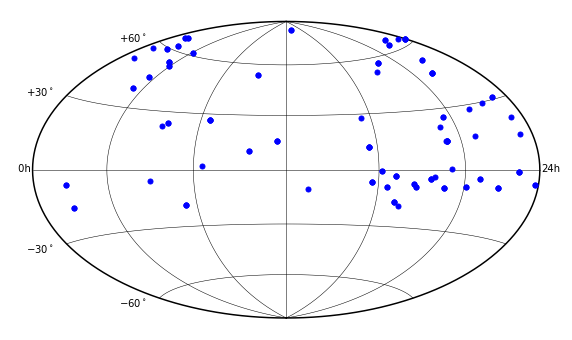

In [13]:
sou_dist_plot(vlbi_timing200["ra_v"], vlbi_timing200["dec_v"])

Make a simple plot.

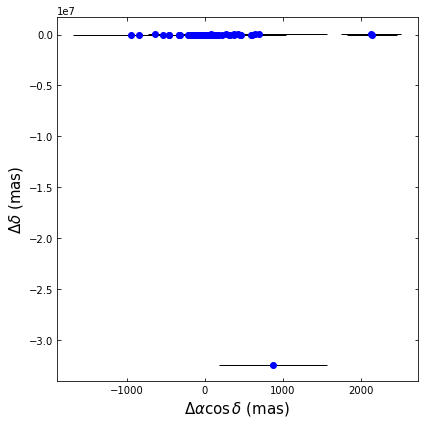

In [14]:
simple_plot(vlbi_timing200)

It is clearly that there is one pulsar (`PSR J0323+3944`) showing extremely large declination offset $\sim$ -30000 arcsec, which is impossible.

In [15]:
vlbi_timing200[vlbi_timing200["ddec"] < -6000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0320+39,J0323+3944,48382.0,DE200,50.86120833333332,30.74791666666667,0.0,0.0,0.0,693.8212399756999,1800.0,0.0,0.0,0.0,ant94,,56000.0,50.86109125,39.7478897222,26.48,-30.78,1.05,1.153,1.0,0.06,0.03,0.04,876.3687232767554,-32400544.976757772,693.8233265713395,1800.0003865307988


The formal uncertainites in RA and Dec are about 900 mas and 1.8 arcsec, which are too huge.

The position offset in declination is also unrealistic, so this source `PSR J0323+3944` should be removed.

In [16]:
vlbi_timing[vlbi_timing["psr_name"] == "J0323+3944"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0320+39,J0323+3944,49290.0,DE200,50.86090833333333,39.74802777777778,44.0,-99.0,0.0,106.40750264590375,300.0,33.0,73.0,0.0,hlk+04,,56000.0,50.86109125,39.7478897222,26.48,-30.78,1.05,1.153,1.0,0.06,0.03,0.04,-19.83433653363161,-68.45864689652126,106.41945781970061,300.0021728980896
B0320+39,J0323+3944,48382.0,DE200,50.86120833333332,30.74791666666667,0.0,0.0,0.0,693.8212399756999,1800.0,0.0,0.0,0.0,ant94,,56000.0,50.86109125,39.7478897222,26.48,-30.78,1.05,1.153,1.0,0.06,0.03,0.04,876.3687232767554,-32400544.976757772,693.8233265713395,1800.0003865307988


It should be noted that the positional offset for this pulsar is about -68 mas in declination in **hlk+04**, therefore the position measurement given in **ant94** is problematic.

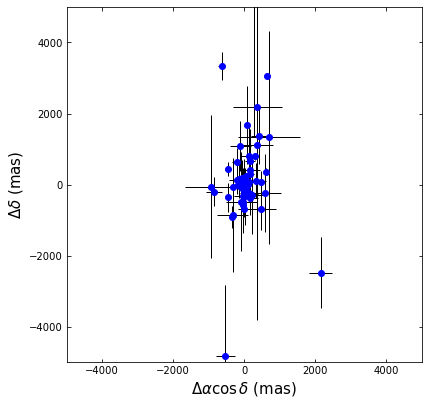

In [17]:
val_max = 5000
simple_plot(vlbi_timing200, axis_lim=[-val_max, val_max, -val_max, val_max])

First, we visually check the positional offsets.

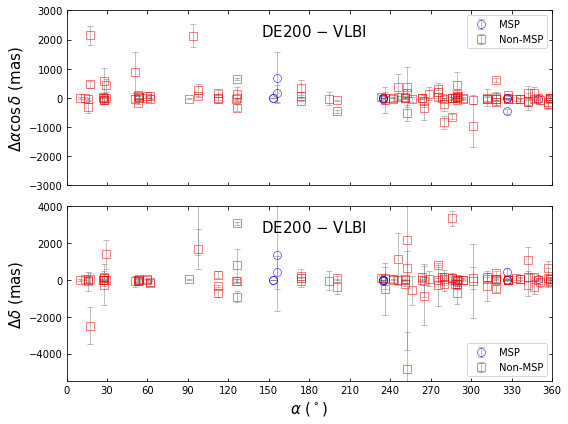

In [18]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-3000, 3000, -5500, 4000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.4, 0.85, "DE200 $-$ VLBI"],
    #                  fig_name="vlbi_pos-oft-vs-ra-de200.eps",
    ref="v",
    xaxis="ra",
    divided=True,
)

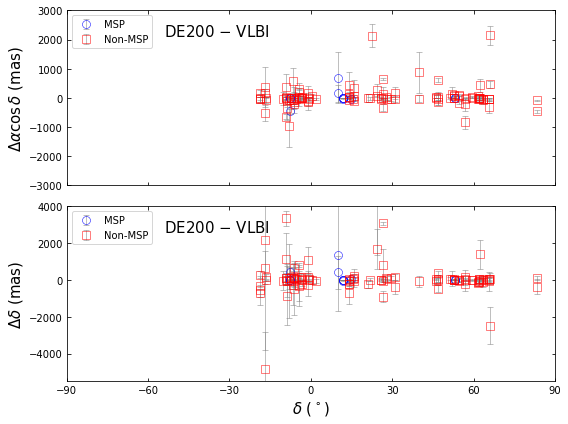

In [19]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-3000, 3000, -5500, 4000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.85, "DE200 $-$ VLBI"],
    #                  fig_name="vlbi_pos-oft-vs-dec-de200.eps",
    ref="v",
    xaxis="dec",
    divided=True,
)

Check how many PSRs yield an offset > 1 arcsec.

In [20]:
vlbi_timing200[np.fabs(vlbi_timing200["dra"]) >= 1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0105+65,J0108+6608,48464.0,DE200,17.09570833333333,66.14202777777778,0.0,0.0,0.0,319.00231869052317,1000.0,0.0,0.0,0.0,ant94,,56000.0,17.0937704167,66.1429163889,-32.75,35.16,0.47,1.82,1.0,0.04,0.05,0.04,2145.979366318704,-2473.563325416725,319.0085780136513,1000.001032121625
B0611+22,J0614+2229,49674.0,DE200,93.5715,22.51,0.0,0.0,0.0,384.07368292234065,17000.0,0.0,0.0,0.0,hlk+04,,56000.0,93.5708575,22.4991244444,-0.23,-1.22,0.28,1.386,1.0,0.05,0.07,0.03,2132.9633665220513,39130.870194230236,384.07716000135736,17000.000072642746


In [21]:
vlbi_timing200[np.fabs(vlbi_timing200["ddec"]) >= 1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0105+65,J0108+6608,48464.0,DE200,17.09570833333333,66.14202777777778,0.0,0.0,0.0,319.00231869052317,1000.0,0.0,0.0,0.0,ant94,,56000.0,17.0937704167,66.1429163889,-32.75,35.16,0.47,1.82,1.0,0.04,0.05,0.04,2145.979366318704,-2473.563325416725,319.0085780136513,1000.001032121625
B0154+61,J0157+6212,48416.0,DE200,29.45833333333333,62.20752777777778,0.0,0.0,0.0,228.27945504726557,800.0,0.0,0.0,0.0,ant94,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,427.42629684670936,1382.4286631507969,228.2899681910071,800.0012986519107
B0320+39,J0323+3944,48382.0,DE200,50.86120833333332,30.74791666666667,0.0,0.0,0.0,693.8212399756999,1800.0,0.0,0.0,0.0,ant94,,56000.0,50.86109125,39.7478897222,26.48,-30.78,1.05,1.153,1.0,0.06,0.03,0.04,876.3687232767554,-32400544.976757772,693.8233265713395,1800.0003865307988
B0611+22,J0614+2229,49674.0,DE200,93.5715,22.51,0.0,0.0,0.0,384.07368292234065,17000.0,0.0,0.0,0.0,hlk+04,,56000.0,93.5708575,22.4991244444,-0.23,-1.22,0.28,1.386,1.0,0.05,0.07,0.03,2132.9633665220513,39130.870194230236,384.07716000135736,17000.000072642746
B0626+24,J0629+2415,49438.0,DE200,97.27386666666666,24.262027777777778,32.0,400.0,0.0,49.86935738776835,1100.0,15.0,300.0,0.0,hlk+04,,56000.0,97.27386375,24.2615405556,3.63,-4.61,0.33,1.368,1.0,0.19,0.15,0.05,74.7884026233347,1671.177608652694,50.00476173489959,1100.0037555870495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B1620-09,J1623-0908,48382.0,DE200,245.82374999999996,-9.146694444444444,0.0,0.0,0.0,438.62866611115396,1400.0,0.0,0.0,0.0,ant94,,56000.0,245.8235829167,-9.1468702778,-10.77,23.51,0.59,1.481,2.0,0.13,0.17,0.1,369.22194317505455,1123.3469109382702,438.6395465555791,1400.0059185067898
J1650-1654,J1650-1654,50862.0,DE200,252.61337499999996,-16.91111111111111,0.0,0.0,0.0,686.5359332897926,6000.0,0.0,0.0,0.0,hlk+04,,56000.0,252.6132058333,-16.911745,-15.02,-6.56,-0.09,10.046,20.0,0.09,0.15,0.03,371.37578271189824,2189.719972619655,686.6105975468724,6000.033704268665


In total, there are 12 pulsars showing offset > 1000 mas.

- J0323+3944
- J0108+6608
- J0614+2229
- J0157+6212
- J0629+2415
- J0826+2637
- J1022+1001
- J1623-0908
- J1650-1654
- J1901-0906
- J2248-0101

I first looked at `J0108+6608`.

This pulsars only has two timing solutions, all in the DE200 frames.

The timing positional uncertainties in **ant94** are 789 mas and 1 arcsec, and the offsets are 2.5 arcsec and -2.5 arcsec.

The timing positional uncertainty in **hlk+04** is about 300 mas, and the offsets are 784 mas and 78 mas.

In [22]:
vlbi_timing[vlbi_timing["psr_name"] == "J0108+6608"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0105+65,J0108+6608,50011.0,DE200,17.094458333333332,66.14277777777778,0.0,0.0,0.0,122.68956803834118,300.0,0.0,0.0,0.0,hlk+04,,56000.0,17.0937704167,66.1429163889,-32.75,35.16,0.47,1.82,1.0,0.04,0.05,0.04,464.63551949892843,77.5180708744887,122.70481931610759,300.00278690883613
B0105+65,J0108+6608,48464.0,DE200,17.09570833333333,66.14202777777778,0.0,0.0,0.0,319.00231869052317,1000.0,0.0,0.0,0.0,ant94,,56000.0,17.0937704167,66.1429163889,-32.75,35.16,0.47,1.82,1.0,0.04,0.05,0.04,2145.979366318704,-2473.563325416725,319.0085780136513,1000.001032121625


Next one is `PSR J0614+2229`.

There are two timing solutions, one in DE200 frame (**hlk+04**) and the other one in DE421 (**lys+20**).

The timing positional uncertainties are same in these two solutions (416 mas and 17 arcsec).

And same for the positional offsets (2.1 arcsec and 29 arcsec).

It should be noted that similar offsets are found for timing minus Gaia position.

In [23]:
vlbi_timing[vlbi_timing["psr_name"] == "J0614+2229"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0611+22,J0614+2229,56000.0,DE421,93.57149999999999,22.51,0.0,0.0,0.0,384.07368292234065,17000.0,0.0,0.0,0.0,lys+20,,56000.0,93.5708575,22.4991244444,-0.23,-1.22,0.28,1.386,1.0,0.05,0.07,0.03,2136.946884613048,39152.0001600071,384.0761837312106,17000.000029411764
B0611+22,J0614+2229,49674.0,DE200,93.5715,22.51,0.0,0.0,0.0,384.07368292234065,17000.0,0.0,0.0,0.0,hlk+04,,56000.0,93.5708575,22.4991244444,-0.23,-1.22,0.28,1.386,1.0,0.05,0.07,0.03,2132.9633665220513,39130.870194230236,384.07716000135736,17000.000072642746


For `PSR J0157+6212`, its DE200 position is similar to `PSR J0323+3944`, **ant94** gives an offset of 411 mas and 1382 mas while **hlk+04** gives an offset of -33 mas and 24 mas.

Its DE421 position in **lys+20** shows an offset of -1 arcsec in RA and 0.65 arcsec in Dec but the offsets are all smaller than 100 mas in **dym+20**.

It should be noted that the timing proper motions differs between **lys+20** and **dym+20**, -51 mas/yr vs -11 mas/yr in RA and 81 mas/yr vs 30 mas/yr in Dec. (The result in **lys+20** is identical to those in **hlk+04**).

VLBI gives a proper motion of 1.52 mas/yr in RA and 44.81 mas/yr in Dec.

In [24]:
vlbi_timing[vlbi_timing["psr_name"] == "J0157+6212"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0154+61,J0157+6212,56000.0,DE421,29.457499999999996,62.20758333333334,-51.0,81.0,0.0,228.2790350933708,700.0,36.0,33.0,0.0,lys+20,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,-1002.9518348517137,652.0000800122715,228.28010527455172,700.0007142853499
B0154+61,J0157+6212,54594.0,DE421,29.458124999999995,62.20733333333334,-11.0,30.0,0.0,65.22312139548774,200.0,23.0,30.0,0.0,dym+20,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,52.01207877494412,-75.50749014945214,65.22800277316354,200.0025925958244
B0154+61,J0157+6212,49709.0,DE200,29.45807083333333,62.20719444444445,-51.0,81.0,0.0,58.701079225575526,130.0,36.0,33.0,0.0,hlk+04,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,-18.581940713460153,23.79942291571373,58.73050232001019,130.00669848080273
B0154+61,J0157+6212,48416.0,DE200,29.45833333333333,62.20752777777778,0.0,0.0,0.0,228.27945504726557,800.0,0.0,0.0,0.0,ant94,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,427.42629684670936,1382.4286631507969,228.2899681910071,800.0012986519107


For `PSR J0629+2415`, there are three timing solutions, two in DE200 frame (**ant94** and **hlk+04**) and one in DE421 frame (**lys+20**).

The offsets in **ant94** are 270 mas and 5358 mas, 69 mas and 1671 mas in **hlk+04**, and 584 mas and 8454 mas in **lys+20**.

The timing proper motion did not match the VLBI one.

In [25]:
vlbi_timing[vlbi_timing["psr_name"] == "J0629+2415"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0626+24,J0629+2415,49438.0,DE200,97.27386666666666,24.262027777777778,32.0,400.0,0.0,49.86935738776835,1100.0,15.0,300.0,0.0,hlk+04,,56000.0,97.27386375,24.2615405556,3.63,-4.61,0.33,1.368,1.0,0.19,0.15,0.05,74.7884026233347,1671.177608652694,50.00476173489959,1100.0037555870495
B0626+24,J0629+2415,48382.0,DE200,97.27392499999999,24.263055555555557,0.0,0.0,0.0,211.94305527820012,4000.0,0.0,0.0,0.0,ant94,,56000.0,97.27386375,24.2615405556,3.63,-4.61,0.33,1.368,1.0,0.19,0.15,0.05,276.73600381105575,5357.849312968265,211.9845136959351,4000.0013484717274
B0626+24,J0629+2415,56000.0,DE421,97.27404166666665,24.26388888888889,32.0,400.0,0.0,249.34313624313305,6000.0,15.0,300.0,0.0,lys+20,,56000.0,97.27386375,24.2615405556,3.63,-4.61,0.33,1.368,1.0,0.19,0.15,0.05,583.9305901700707,8453.999840001812,249.34688892296532,6000.000083333332


For `PSR J0826+2637`, there are four timing solutions in DE200 (**ant94**, **dgm+96**, **wmz+01**, and **hlk+04**) and one in DE405 (**zhw+05**).

The position offsets in DE200 are about -472/-914, 22/796, 572/3064, and -184/-36 mas for **ant94**, **dgm+96**, **wmz+01**, and **hlk+04**.

**hlk+04** also estimated the proper motion, which maybe result in a smaller offset in declination.

For **zhw+05**, offsets are 142/549 mas.

VLBI proper motions are 63 and -97 mas/yr.

In [26]:
vlbi_timing[vlbi_timing["psr_name"] == "J0826+2637"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0823+26,J0826+2637,49178.0,DE200,126.71429166666667,26.623305555555557,0.0,0.0,0.0,239.75731537617824,900.0,0.0,0.0,0.0,dgm+96,,56000.0,126.7146116667,26.6225825,62.99,-96.73,2.01,1.341,1.0,0.02,0.09,0.01,146.64075829045163,796.3140041130371,239.76135655847233,900.0021253934214
B0823+26,J0826+2637,48383.0,DE200,126.71409999999999,26.62288888888889,0.0,0.0,0.0,107.89118521608845,300.0,0.0,0.0,0.0,ant94,,56000.0,126.7146116667,26.6225825,62.99,-96.73,2.01,1.341,1.0,0.02,0.09,0.01,-333.100355770468,-914.2276796638323,107.90032477964532,300.00753769566853
B0823+26,J0826+2637,46450.0,DE200,126.71409708333334,26.623275,65.0,-103.0,0.0,19.180590357553783,70.0,3.0,8.0,0.0,hlk+04,,56000.0,126.7146116667,26.6225825,62.99,-96.73,2.01,1.341,1.0,0.02,0.09,0.01,-9.127313075461307,-36.14852840685576,19.23452060038444,70.04668064271245
B0823+26,J0826+2637,51700.0,DE200,126.71458333333334,26.62375,0.0,0.0,0.0,23.975638310310153,70.0,0.0,0.0,0.0,wmz+01,,56000.0,126.7146116667,26.6225825,62.99,-96.73,2.01,1.341,1.0,0.02,0.09,0.01,650.3802192185644,3064.221081455014,24.014265604486127,70.01516009053945
B0823+26,J0826+2637,52398.0,DE405,126.71448333333335,26.623,0.0,0.0,0.0,1078.9108033749746,400.0,0.0,0.0,0.0,zhw+05,,56000.0,126.7146116667,26.6225825,62.99,-96.73,2.01,1.341,1.0,0.02,0.09,0.01,208.17311122885238,549.0740314891351,1078.911654780774,400.002234689363


For `PSR J1623-0908`, there are three timing solutions: 

- DE200: **ant94**, **hkl+04**
- DE430: **lbs+20**

The comparison between DE200 timing solutions and VLBI solution is similar to that of `PSR J0629+2415`.

For the new timing solution given in **lbs+20**, the Dec offset is about -348 mas, comparable to the Dec formal uncertaity of timing solution.

In [27]:
vlbi_timing[vlbi_timing["psr_name"] == "J1623-0908"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B1620-09,J1623-0908,57600.0,DE430,245.8235777837,-9.1469383194,0.0,0.0,0.0,59.10809644543968,310.32,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,245.8235829167,-9.1468702778,-10.77,23.51,0.59,1.481,2.0,0.13,0.17,0.1,28.93481939180823,-347.9367552106058,59.129389696324544,310.3273384206744
B1620-09,J1623-0908,48382.0,DE200,245.82374999999996,-9.146694444444444,0.0,0.0,0.0,438.62866611115396,1400.0,0.0,0.0,0.0,ant94,,56000.0,245.8235829167,-9.1468702778,-10.77,23.51,0.59,1.481,2.0,0.13,0.17,0.1,369.22194317505455,1123.3469109382702,438.6395465555791,1400.0059185067898
B1620-09,J1623-0908,48715.0,DE200,245.82365,-9.147,-16.0,9.0,0.0,58.48377192968744,200.0,12.0,48.0,0.0,hlk+04,,56000.0,245.8235829167,-9.1468702778,-10.77,23.51,0.59,1.481,2.0,0.13,0.17,0.1,23.61872391166555,1.9127425580368003,58.55995197276758,200.03873821723022


For `PSR J1022+1001`, there are two DE200 timing solutions, one (**cst96**) giving a Dec offset of 3 arcsec and the other one giving a Dec offset of 0.9 arcsec. 

The timing uncertainties in Dec are 1.3 arcsec and 0.4 arcsec, respectively.

Similar large offset > 1 arcsec is also found in **lbs+20**, most likely due to errors in the corresponding timing solution.

The offset is about 50 mas or less in several solutions, e.g., **rhc+16** (DE421) and **rsc+21** (DE436).

In [28]:
vlbi_timing[vlbi_timing["psr_name"] == "J1022+1001"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1022+1001,J1022+1001,53589.0,DE405,155.74167916666667,10.031322222222222,-17.02,0.0,1.8,43.634657307105016,130.0,0.14,0.0,0.6000000000000001,vbc+09,,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,9.537769344337619,31.899396607033978,43.66089530613138,130.01553451562935
J1022+1001,J1022+1001,57600.0,DE430,155.7430707446,10.0349714028,-11.934,0.0,0.0,1923.1031261540356,5020.1,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,5106.148526725335,13107.562782562136,1923.103705816646,5020.1004001185465
J1022+1001,J1022+1001,53100.0,DE405,155.7416583333333,10.03125,16.8,0.0,0.0,58.17955604858966,100.0,0.4,0.0,0.0,hbo06,,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,-84.25054772841956,-220.61666088793712,58.19965524616313,100.02028162284914
J1022+1001,J1022+1001,54500.0,DE421,155.7416695983,10.0313269472,-17.086,0.0,1.105,17.473804882212903,45.60201434,0.025302,0.0,0.201815,rhc+16,PPTA-DR1e,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,12.756609453701763,34.96683885260409,17.537318782759908,45.64601725139997
J1022+1001,J1022+1001,51246.0,DE200,155.74175000000002,10.031416666666667,-361.0,-900.0,0.0,290.89763056013976,900.0,167.0,500.0,0.0,hlk+04,,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,165.12336123767716,407.758041371523,290.9021081367319,900.0023069240439
J1022+1001,J1022+1001,55000.0,DE421,155.74166333333332,10.03132777777778,-18.2,-3.0,0.72,21.817328279345794,60.0,6.4,16.0,0.2,dcl+16,EPTA,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,10.930817048861778,30.304625906964585,21.86769493604832,60.03338026668363
J1022+1001,J1022+1001,55637.0,DE436,155.7416458333333,10.031302777777778,-19.0,-5.0,1.55,14.544886642182929,40.0,3.0,9.0,0.16,rsc+21,PPTA-DR2e,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,-25.137758288459047,-69.44439531436669,14.61977173994174,40.04997988695946
J1022+1001,J1022+1001,49780.0,DE200,155.74191666666664,10.031666666666668,0.0,0.0,0.0,872.6922180939347,3000.0,0.0,0.0,0.0,cst96,,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,696.1871314821459,1330.1945643053207,872.6938833603616,3000.000710166815


For `PSR J1650-1654`, this pulsar only have three timing solutions in the DE200 frame and the computed poisitional differences do not agree with each other.

**idb98** solution yields an offset of -4.8 arcsec in Dec while **hlk+04** gives an offset of 2.2 arcsec.

It should be noted that the timing declination uncertainties are 2 and 6 arcsec.

In [29]:
vlbi_timing[vlbi_timing["psr_name"] == "J1650-1654"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1650-1654,J1650-1654,50862.0,DE200,252.61337499999996,-16.91111111111111,0.0,0.0,0.0,686.5359332897926,6000.0,0.0,0.0,0.0,hlk+04,,56000.0,252.6132058333,-16.911745,-15.02,-6.56,-0.09,10.046,20.0,0.09,0.15,0.03,371.37578271189824,2189.719972619655,686.6105975468724,6000.033704268665
J1650-1654,J1650-1654,49361.4,DE200,252.6133333333333,-16.911527777777778,0.0,0.0,0.0,137.3068830673947,900.0,0.0,0.0,0.0,dsb+98,,56000.0,252.6132058333,-16.911745,-15.02,-6.56,-0.09,10.046,20.0,0.09,0.15,0.03,166.1542349533424,662.7687446949416,137.68361586571143,900.2263231237613
J1650-1654,J1650-1654,49899.9,DE200,252.61312499999997,-16.913055555555555,0.0,0.0,0.0,274.6115396797362,2000.0,0.0,0.0,0.0,idb98,,56000.0,252.6132058333,-16.911745,-15.02,-6.56,-0.09,10.046,20.0,0.09,0.15,0.03,-529.2672558325623,-4827.559845957296,274.7993434742174,2000.1015664020285


For `PSR J1901-0906`, the DE200 position in **idb98** shows a declination difference of 3.3 arcsec, which is not found in **hlk+04** (47 mas) and **dsb+98** (128 mas).

In [30]:
vlbi_timing[vlbi_timing["psr_name"] == "J1901-0906"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1901-0906,J1901-0906,50873.0,DE200,285.4708958333333,-9.103,-1.0,-28.0,0.0,43.873623328101644,300.0,19.0,138.0,0.0,hlk+04,,56000.0,285.4708695833,-9.1030961111,-7.53,-18.21,0.51,4.443,10.0,0.04,0.16,0.07,-12.38840078457061,90.38690045001195,44.10159102542769,300.17502249289004
J1901-0906,J1901-0906,49618.6,DE200,285.4709041666666,-9.102972222222222,0.0,0.0,0.0,43.87362673622616,200.0,0.0,0.0,0.0,dsb+98,,56000.0,285.4708695833,-9.1030961111,-7.53,-18.21,0.51,4.443,10.0,0.04,0.16,0.07,-8.626974099444318,127.84720435050559,44.10355730870699,200.26935443218278
J1901-0906,J1901-0906,57600.0,DE430,285.4709208333333,-9.103305555555556,0.0,0.0,0.0,131.62075751415418,700.0,0.0,0.0,0.0,jbs+19,UTMOST-I,56000.0,285.4708695833,-9.1030961111,-7.53,-18.21,0.51,4.443,10.0,0.04,0.16,0.07,215.16201499648133,-674.2300194702625,131.6958418497216,700.071775781965
J1901-0906,J1901-0906,56000.0,DE430,285.4708633342,-9.1030375389,-7.53,-18.21,0.51,58.302189469385986,245.3,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,285.4708695833,-9.1030961111,-7.53,-18.21,0.51,4.443,10.0,0.04,0.16,0.07,-22.213419169876573,210.85991999498785,58.47123691118721,245.50374742557395
J1901-0906,J1901-0906,49901.0,DE200,285.47072499999996,-9.102083333333333,0.0,0.0,0.0,87.74747158153136,400.0,0.0,0.0,0.0,idb98,,56000.0,285.4708695833,-9.1030961111,-7.53,-18.21,0.51,4.443,10.0,0.04,0.16,0.07,-639.6814069566043,3341.9266035038245,87.86242167858316,400.13390009392623


For `PSR J2248-0101`, the DE200 position in **idb98** shows a declination difference of 1.1 arcsec, which is not found in **hlk+04** (-260 mas) and **dsb+98** (168 mas).

In [31]:
vlbi_timing[vlbi_timing["psr_name"] == "J2248-0101"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J2248-0101,J2248-0101,50866.0,DE200,342.11210833333337,-1.0300277777777778,-12.0,0.0,0.0,239.92244401684948,600.0,79.0,200.0,0.0,hlk+04,,56000.0,342.1120245833,-1.0300236111,-10.55,-17.41,0.26,1.5,1.0,0.12,0.27,0.07,153.1592727871057,-259.7171926348833,239.93306195345295,600.0128358576297
J2248-0101,J2248-0101,56000.0,DE430,342.1120208275,-1.0300137222,-10.55,-17.41,0.26,99.6712812572507,223.17,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,342.1120245833,-1.0300236111,-10.55,-17.41,0.26,1.5,1.0,0.12,0.27,0.07,-13.518695330495442,35.60003999991678,99.68256772105127,223.17224043325817
J2248-0101,J2248-0101,49367.3,DE200,342.1120375,-1.0298888888888889,0.0,0.0,0.0,119.96122723635239,300.0,0.0,0.0,0.0,dsb+98,,56000.0,342.1120245833,-1.0300236111,-10.55,-17.41,0.26,1.5,1.0,0.12,0.27,0.07,-145.08846169193507,168.84579983610527,119.9903938198292,300.0417298151897
J2248-0101,J2248-0101,49901.1,DE200,342.11204166666664,-1.0296388888888888,0.0,0.0,0.0,299.90309161211445,700.0,0.0,0.0,0.0,idb98,,56000.0,342.1120245833,-1.0300236111,-10.55,-17.41,0.26,1.5,1.0,0.12,0.27,0.07,-114.67171696124386,1094.291081823264,299.91353640914383,700.0152325127333


I also noticed that significant offsets of ~ 500 mas for MSP `PSR J2145-0750`, which comes from **bhl+94**, but the offsets are much smaller in other author's timing solutions.

In [32]:
vlbi_timing[vlbi_timing["psr_name"] == "J2145-0750"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J2145-0750,J2145-0750,53040.0,DE405,326.4602671666666,-7.838455527777778,-9.66,-8.9,1.6,0.4416301388785477,1.4000000000000001,0.15,0.4,0.5,vbc+09,,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,1.9849823352570466,0.35321119937098167,1.5837657273631578,4.300229184793132
J2145-0750,J2145-0750,57600.0,DE430,326.4602329166667,-7.838497222222222,-9.4,-12.8,0.0,2.944200630903625,7.0,0.3,0.8,0.0,jbs+19,UTMOST-I,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,-1.4344190646548802,-36.13693253825908,3.3026074944094144,8.07189156686798
J2145-0750,J2145-0750,55000.0,DE421,326.4602524708333,-7.838468777777777,-9.58,-8.86,1.53,0.13248903744560134,0.4,0.04,0.1,0.11,dcl+16,EPTA,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,0.606745045439542,1.4855178407847054,1.4959086429777126,4.027495027700724
J2145-0750,J2145-0750,50766.0,DE200,326.4602804166667,-7.8384366666666665,-10.0,-10.0,0.0,4.416301588924614,14.0,1.7,5.0,0.0,hlk+04,,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,-9.968752493453078,11.597769721096618,4.694727881792186,14.617226324911238
J2145-0750,J2145-0750,55000.0,DE421,326.4602524875,-7.8384688361,-9.559,-8.923,1.771,0.20355544719839788,0.55725038,0.041103,0.110009,0.163626,vlh+16,IPTA-DR1,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,0.6661844137781747,1.2755578393997486,1.5038697228072315,4.046139417292019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2145-0750,J2145-0750,57600.0,DE430,326.4602303467,-7.8384907083,0.0,0.0,0.0,11.808305658004317,33.636,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,-10.599854190719638,-12.686812538834936,11.902729998616817,33.87529969560823
J2145-0750,J2145-0750,48978.7,DE200,326.4601666666666,-7.838305555555555,0.0,0.0,0.0,73.60504966930678,200.0,0.0,0.0,0.0,bhl+94,,56000.0,326.460245,-7.8384761111,-9.51,-9.1,1.6,1.486,4.0,0.04,0.09,0.03,-462.1795532294948,439.0671233965559,73.62406396480893,200.04747752279425


Set an upper limit on the positional offset.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


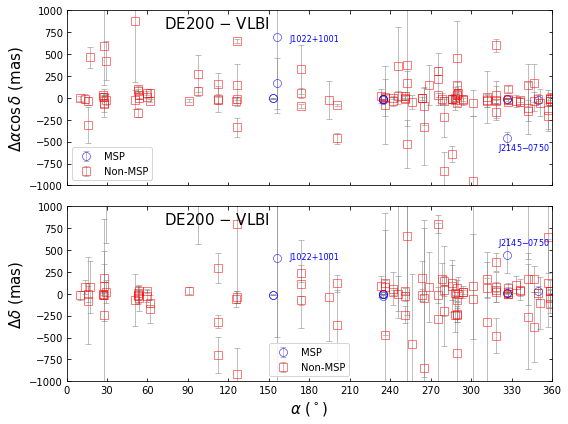

In [33]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-1000, 1000, -1000, 1000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    fig_name="vlbi_pos-oft-vs-ra-de200.eps",
    add_text=[0.2, 0.9, "DE200 $-$ VLBI"],
    add_text_msp=[[165, 650, "J1022+1001", 0],
                  [165, 400, "J1022+1001", 1],
                  [320, -600, "J2145$-$0750", 0],
                  [320, 550, "J2145$-$0750", 1]],
    ref="v",
    xaxis="ra",
    divided=True,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


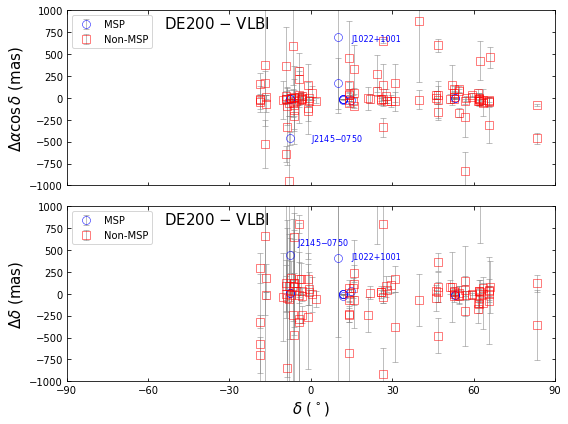

In [34]:
pos_oft_vs_coord(
    vlbi_timing200,
    [-1000, 1000, -1000, 1000],
    vlbi_timing200["dra"],
    vlbi_timing200["ddec"],
    add_text=[0.2, 0.9, "DE200 $-$ VLBI"],
    fig_name="vlbi_pos-oft-vs-dec-de200.eps",
    add_text_msp=[[15, 650, "J1022+1001", 0],
                  [15, 400, "J1022+1001", 1],
                  [0, -500, "J2145$-$0750", 0],
                  [-5, 550, "J2145$-$0750", 1]],
    ref="v",
    xaxis="dec",
    divided=True,
)

## 2.2 DE405 vs VLBI

In [35]:
mask = vlbi_timing["eph"] == "DE405"
vlbi_timing405 = vlbi_timing[mask]

nb_psr_405 = len(vlbi_timing405.group_by("psr_name").groups)
nb_obs_405 = len(vlbi_timing405)


print("We have", nb_psr_405,
      "pulsars in the sample from DE405 vs. PSRPI comparison with",
      nb_obs_405, "observations.")

# vlbi_timing405

We have 12 pulsars in the sample from DE405 vs. PSRPI comparison with 14 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


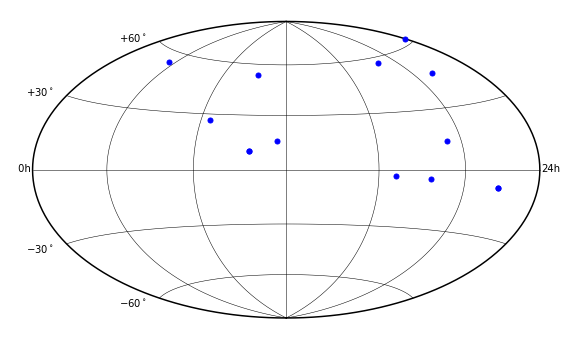

In [36]:
sou_dist_plot(vlbi_timing405["ra_v"], vlbi_timing405["dec_v"])
# ,
#               "../plots/vlbi_de405_psr.eps")

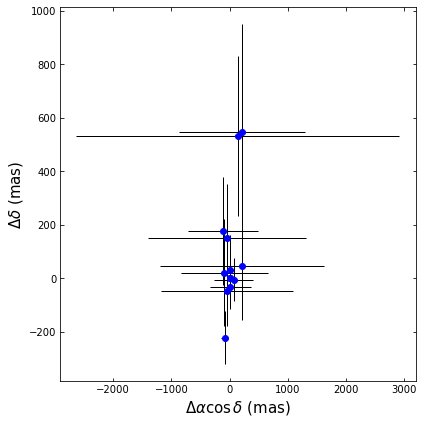

In [37]:
simple_plot(vlbi_timing405)

In [38]:
vlbi_timing405[vlbi_timing405["ddec"] < -200]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1022+1001,J1022+1001,53100.0,DE405,155.7416583333333,10.03125,16.8,0.0,0.0,58.17955604858966,100.0,0.4,0.0,0.0,hbo06,,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,-84.25054772841956,-220.61666088793712,58.19965524616313,100.02028162284914


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


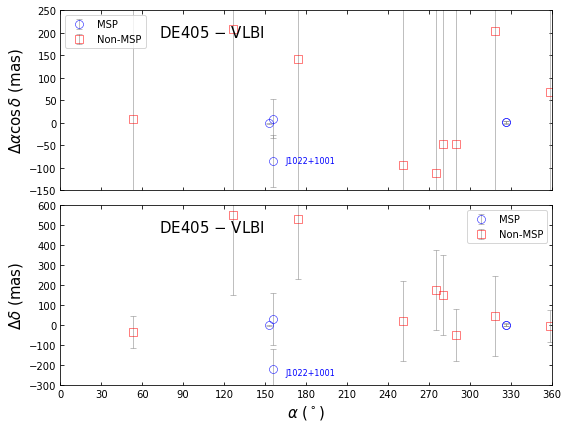

In [39]:
pos_oft_vs_coord(
    vlbi_timing405,
    [-150, 250, -300, 600],
    vlbi_timing405["dra"],
    vlbi_timing405["ddec"],
    add_text=[0.2, 0.85, "DE405 $-$ VLBI"],
    add_text_msp=[[165, -90, "J1022+1001", 0],
                  [165, -250, "J1022+1001", 1]],
    fig_name="vlbi_pos-oft-vs-ra-de405.eps",
    ref="v",
    xaxis="ra",
    divided=True,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


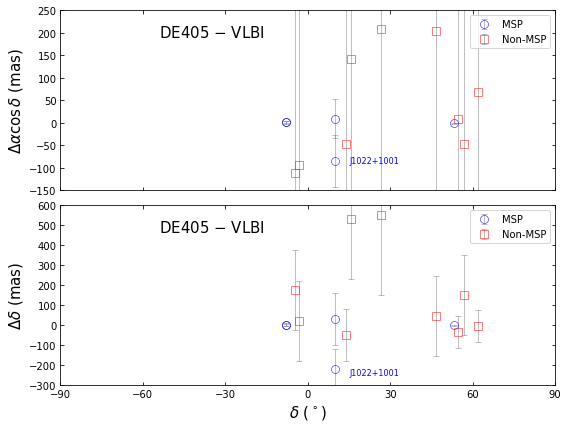

In [40]:
pos_oft_vs_coord(
    vlbi_timing405,
    [-150, 250, -300, 600],
    vlbi_timing405["dra"],
    vlbi_timing405["ddec"],
    fig_name="vlbi_pos-oft-vs-dec-de405.eps",
    add_text=[0.2, 0.85, "DE405 $-$ VLBI"],
    add_text_msp=[[15, -90, "J1022+1001", 0],
                  [15, -250, "J1022+1001", 1]],
    ref="v",
    xaxis="dec",
    divided=True,
)

## 2.3 DE421 vs VLBI

In [41]:
mask = vlbi_timing["eph"] == "DE421"
vlbi_timing421 = vlbi_timing[mask]

nb_psr_421 = len(vlbi_timing421.group_by("psr_name").groups)
nb_obs_421 = len(vlbi_timing421)

print("We have", nb_psr_421,
      "pulsars in the sample from DE421 vs. PSRPI comparison with",
      nb_obs_421, "observations.")
# vlbi_timing421

We have 24 pulsars in the sample from DE421 vs. PSRPI comparison with 36 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


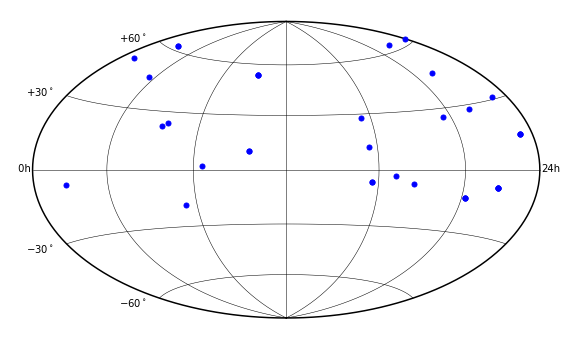

In [42]:
sou_dist_plot(vlbi_timing421["ra_v"], vlbi_timing421["dec_v"])
#               ,
#               "../plots/vlbi_de421_psr.eps")

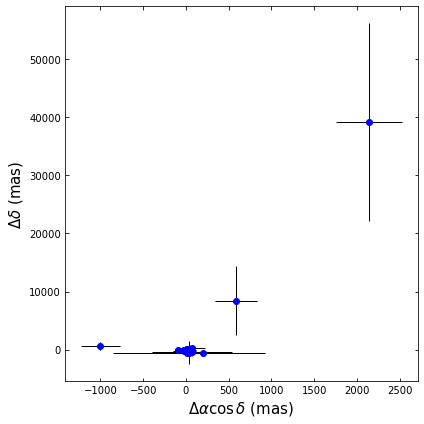

In [43]:
simple_plot(vlbi_timing421)

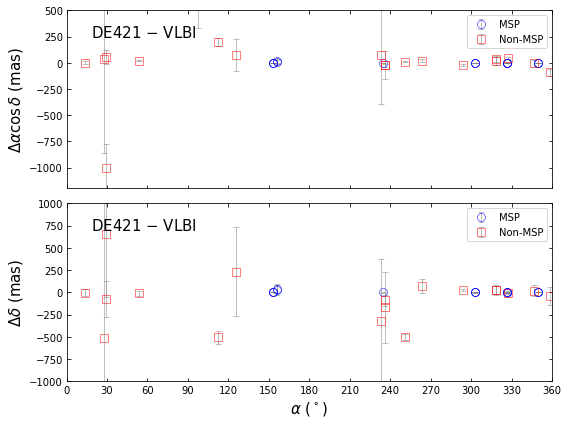

In [44]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-1200, 500, -1000, 1000],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    add_text=[0.05, 0.85, "DE421 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

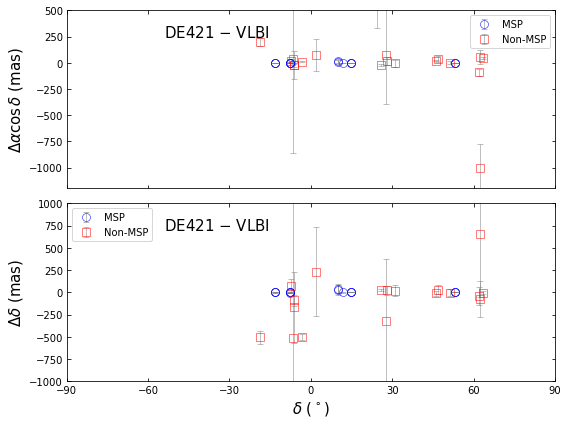

In [45]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-1200, 500, -1000, 1000],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    ref="v",
    xaxis="dec",
    add_text=[0.2, 0.85, "DE421 $-$ VLBI"],
    divided=True,
)

There is one pulsar with offset > 1000 mas.

In [46]:
vlbi_timing421[vlbi_timing421["dra"] < -1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0154+61,J0157+6212,56000.0,DE421,29.457499999999996,62.20758333333334,-51.0,81.0,0.0,228.2790350933708,700.0,36.0,33.0,0.0,lys+20,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,-1002.9518348517137,652.0000800122715,228.28010527455172,700.0007142853499


Check whether there are timing position published by other authors.

In [47]:
vlbi_timing[vlbi_timing["psr_name"] == "J0157+6212"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B0154+61,J0157+6212,56000.0,DE421,29.457499999999996,62.20758333333334,-51.0,81.0,0.0,228.2790350933708,700.0,36.0,33.0,0.0,lys+20,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,-1002.9518348517137,652.0000800122715,228.28010527455172,700.0007142853499
B0154+61,J0157+6212,54594.0,DE421,29.458124999999995,62.20733333333334,-11.0,30.0,0.0,65.22312139548774,200.0,23.0,30.0,0.0,dym+20,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,52.01207877494412,-75.50749014945214,65.22800277316354,200.0025925958244
B0154+61,J0157+6212,49709.0,DE200,29.45807083333333,62.20719444444445,-51.0,81.0,0.0,58.701079225575526,130.0,36.0,33.0,0.0,hlk+04,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,-18.581940713460153,23.79942291571373,58.73050232001019,130.00669848080273
B0154+61,J0157+6212,48416.0,DE200,29.45833333333333,62.20752777777778,0.0,0.0,0.0,228.27945504726557,800.0,0.0,0.0,0.0,ant94,,56000.0,29.4580975,62.2074022222,1.52,44.81,0.55,0.699,1.0,0.1,0.05,0.04,427.42629684670936,1382.4286631507969,228.2899681910071,800.0012986519107


The offset from timing position in `dym+20` is about 40 mas. 

It should be noted that the proper motions differ much for these two authors.

In this case, it is likely caused by errors in `lys+20`.

Set the upper limit on the offset to be 1 arcsec.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


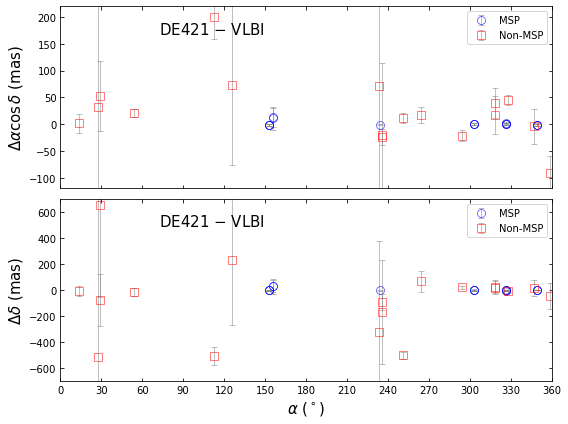

In [48]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-120, 220, -700, 700],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    fig_name="vlbi_pos-oft-vs-ra-de421.eps",
    add_text=[0.2, 0.85, "DE421 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


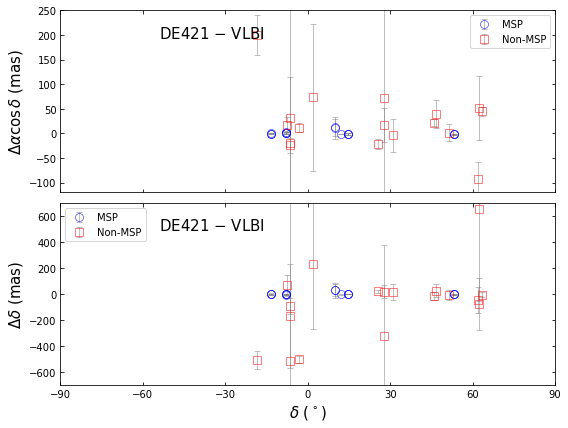

In [49]:
pos_oft_vs_coord(
    vlbi_timing421,
    [-120, 250, -700, 700],
    vlbi_timing421["dra"],
    vlbi_timing421["ddec"],
    fig_name="vlbi_pos-oft-vs-dec-de421.eps",
    ref="v",
    xaxis="dec",
    add_text=[0.2, 0.85, "DE421 $-$ VLBI"],
    divided=True,
)

## 2.4 DE430 vs VLBI

In [50]:
mask = vlbi_timing["eph"] == "DE430"
vlbi_timing430 = vlbi_timing[mask]

nb_psr_430 = len(vlbi_timing430.group_by("psr_name").groups)
nb_obs_430 = len(vlbi_timing430)

print("We have", nb_psr_430,
      "pulsars in the sample from DE430 vs. PSRPI comparison with",
      nb_obs_430, "observations.")
# vlbi_timing430

We have 22 pulsars in the sample from DE430 vs. PSRPI comparison with 36 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


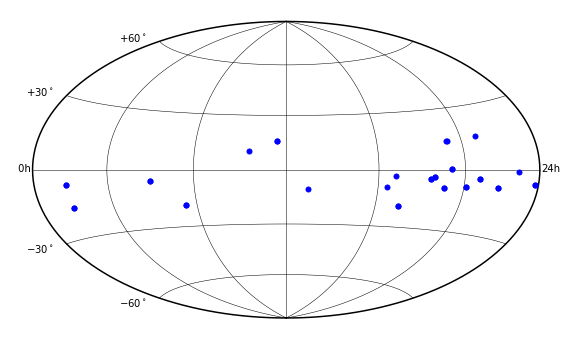

In [51]:
sou_dist_plot(vlbi_timing430["ra_v"], vlbi_timing430["dec_v"])
# ,
#               "../plots/vlbi_de430_psr.eps")

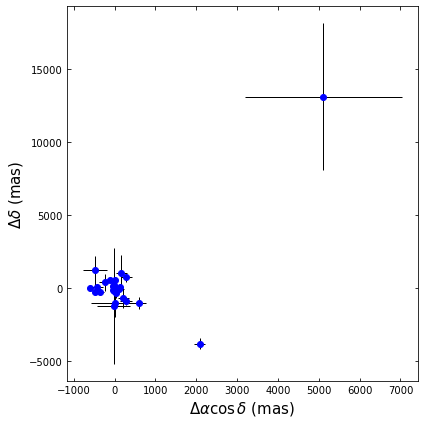

In [52]:
simple_plot(vlbi_timing430)

The data point at the right lower corner is likely to be an outlier.

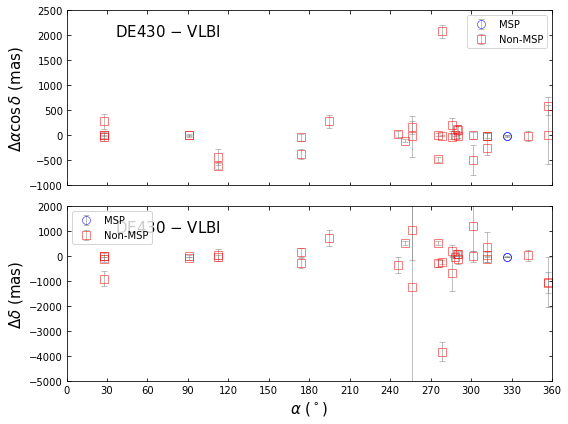

In [53]:
pos_oft_vs_coord(
    vlbi_timing430,
    [-1000, 2500, -5000, 2000],
    vlbi_timing430["dra"],
    vlbi_timing430["ddec"],
    #     fig_name="vlbi_pos-oft-vs-ra-de430.eps",
    add_text=[0.1, 0.85, "DE430 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

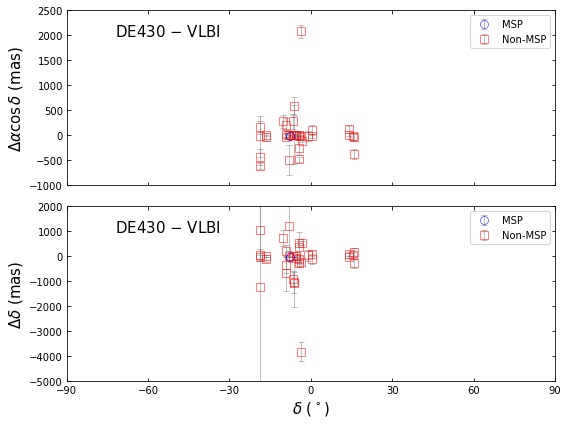

In [54]:
pos_oft_vs_coord(
    vlbi_timing430,
    [-1000, 2500, -5000, 2000],
    vlbi_timing430["dra"],
    vlbi_timing430["ddec"],
    #     fig_name="vlbi_pos-oft-vs-dec-de430.eps",
    add_text=[0.1, 0.85, "DE430 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

Likely, two measurememnts should be removed.

In [55]:
vlbi_timing430[np.fabs(vlbi_timing430["dra"]) > 1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1022+1001,J1022+1001,57600.0,DE430,155.7430707446,10.0349714028,-11.934,0.0,0.0,1923.1031261540356,5020.1,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,5106.148526725335,13107.562782562136,1923.103705816646,5020.1004001185465
B1831-03,J1833-0338,57600.0,DE430,278.4251177337,-3.6522228222,0.0,0.0,0.0,123.62147998732632,373.06,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,278.4245604167,-3.6511827778,-17.41,15.04,0.41,1.497,1.0,0.16,0.34,0.07,2078.53437836469,-3810.0434813425286,123.63253038650781,373.0643133362385


In [56]:
vlbi_timing[vlbi_timing["psr_name"] == "J1833-0338"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B1831-03,J1833-0338,57600.0,DE430,278.4251177337,-3.6522228222,0.0,0.0,0.0,123.62147998732632,373.06,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,278.4245604167,-3.6511827778,-17.41,15.04,0.41,1.497,1.0,0.16,0.34,0.07,2078.53437836469,-3810.0434813425286,123.63253038650781,373.0643133362385
B1831-03,J1833-0338,57600.0,DE430,278.4245375,-3.6512305555555553,-16.0,-3.0,0.0,14.939168172529467,70.0,3.0,9.0,0.0,jbs+19,UTMOST-I,56000.0,278.4245604167,-3.6511827778,-17.41,15.04,0.41,1.497,1.0,0.16,0.34,0.07,-6.067092959002628,-237.88356134106832,15.030336030873437,70.02298397697092
B1831-03,J1833-0338,49698.0,DE200,278.4246416666667,-3.6512083333333334,0.0,0.0,0.0,59.756674169073044,180.0,0.0,0.0,0.0,hlk+04,,56000.0,278.4245604167,-3.6511827778,-17.41,15.04,0.41,1.497,1.0,0.16,0.34,0.07,-8.484844652080714,167.4992723334217,59.839135965692634,180.0983451422911


The result of `J1833-0338` from `UTMOST-I` agrees with those of VLBI well, while that from `UTMOST-II` did not, which I did not understand.

In [57]:
vlbi_timing430[np.fabs(vlbi_timing430["ddec"]) > 1000]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1022+1001,J1022+1001,57600.0,DE430,155.7430707446,10.0349714028,-11.934,0.0,0.0,1923.1031261540356,5020.1,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,5106.148526725335,13107.562782562136,1923.103705816646,5020.1004001185465
B1700-18,J1703-1846,57600.0,DE430,255.9629282825,-18.7704763056,0.0,0.0,0.0,128.2440495685527,1185.6,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,255.96288125,-18.7707902778,-0.75,16.96,0.35,2.84,6.0,0.1,0.23,0.05,163.59703044921105,1056.005601043025,128.27623997806796,1185.6156101852177
B1700-18,J1703-1846,57600.0,DE430,255.962875,-18.77111111111111,0.0,0.0,0.0,403.4042843535918,4000.0,0.0,0.0,0.0,jbs+19,UTMOST-I,56000.0,255.96288125,-18.7707902778,-0.75,16.96,0.35,2.84,6.0,0.1,0.23,0.05,-18.017881273971135,-1229.2942389595828,403.414518985129,4000.004626886682
B1831-03,J1833-0338,57600.0,DE430,278.4251177337,-3.6522228222,0.0,0.0,0.0,123.62147998732632,373.06,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,278.4245604167,-3.6511827778,-17.41,15.04,0.41,1.497,1.0,0.16,0.34,0.07,2078.53437836469,-3810.0434813425286,123.63253038650781,373.0643133362385
B2003-08,J2006-0807,57600.0,DE430,301.5680416666667,-8.116944444444444,0.0,0.0,0.0,294.0190380567161,1000.0,0.0,0.0,0.0,jbs+19,UTMOST-I,56000.0,301.5681875,-8.1172686111,-6.18,-10.62,0.42,1.485,3.0,0.07,0.17,0.1,-492.6682329429264,1213.5215205765953,294.02294807114924,1000.0047772742187
J2346-0609,J2346-0609,57600.0,DE430,356.7106176329,-6.1669556139,0.0,0.0,0.0,181.05132173055796,408.15,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,356.7104075,-6.1666386111,37.39,-20.23,0.28,1.491,2.0,0.04,0.11,0.04,588.3120280659814,-1052.5913257225845,181.05754578113866,408.1551845692212
J2346-0609,J2346-0609,57600.0,DE430,356.71045833333335,-6.166944444444445,0.0,0.0,0.0,593.076162615504,1000.0,0.0,0.0,0.0,jbs+19,UTMOST-I,56000.0,356.7104075,-6.1666386111,37.39,-20.23,0.28,1.491,2.0,0.04,0.11,0.04,18.151918065887475,-1012.3812857241282,593.0780626921205,1000.0021160931286


In [58]:
vlbi_timing[vlbi_timing["psr_name"] == "J2006-0807"]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
B2003-08,J2006-0807,49766.0,DE200,301.5682,-8.117194444444445,2.0,-76.0,0.0,147.00942754154903,600.0,49.0,171.0,0.0,hlk+04,,56000.0,301.5681875,-8.1172686111,-6.18,-10.62,0.42,1.485,3.0,0.07,0.17,0.1,-60.929616511953895,85.74032960720562,147.0217821369002,600.0145155039589
B2003-08,J2006-0807,57600.0,DE430,301.5680416666667,-8.116944444444444,0.0,0.0,0.0,294.0190380567161,1000.0,0.0,0.0,0.0,jbs+19,UTMOST-I,56000.0,301.5681875,-8.1172686111,-6.18,-10.62,0.42,1.485,3.0,0.07,0.17,0.1,-492.6682329429264,1213.5215205765953,294.02294807114924,1000.0047772742187
B2003-08,J2006-0807,48383.0,DE200,301.5679583333333,-8.117222222222223,0.0,0.0,0.0,735.0470868808762,2000.0,0.0,0.0,0.0,ant94,,56000.0,301.5681875,-8.1172686111,-6.18,-10.62,0.42,1.485,3.0,0.07,0.17,0.1,-945.6134599473482,-54.47174431382202,735.0500364992272,2000.005392131154
B2003-08,J2006-0807,56000.0,DE430,301.5681876625,-8.117269,-6.18,-10.62,0.42,70.7365131217463,231.71,0.0,0.0,0.0,lbs+20,UTMOST-II,56000.0,301.5681875,-8.1172686111,-6.18,-10.62,0.42,1.485,3.0,0.07,0.17,0.1,0.5791389233356251,-1.4000400007319056,70.75209900506829,231.72942001394645


This time, the timing position of `J2006-0807` in the `UTMOST-II` show offset < 5 mas to the VLBI position while the one in the `UTMOST-I` gives an offset > 1000 mas in the declination.

Discard offsets > 1000 mas.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


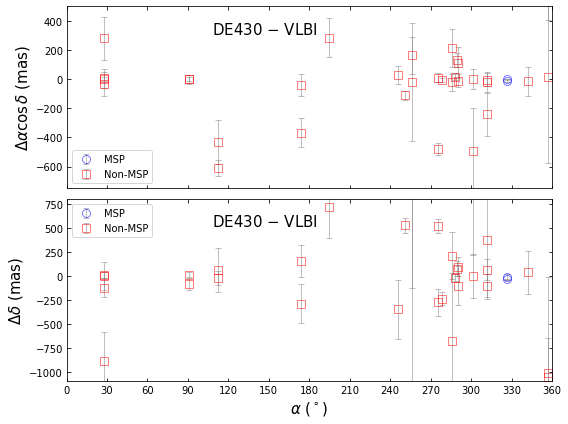

In [59]:
pos_oft_vs_coord(
    vlbi_timing430,
    [-750, 500, -1100, 800],
    vlbi_timing430["dra"],
    vlbi_timing430["ddec"],
    fig_name="vlbi_pos-oft-vs-ra-de430.eps",
    add_text=[0.3, 0.85, "DE430 $-$ VLBI"],
    ref="v",
    xaxis="ra",
    divided=True,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


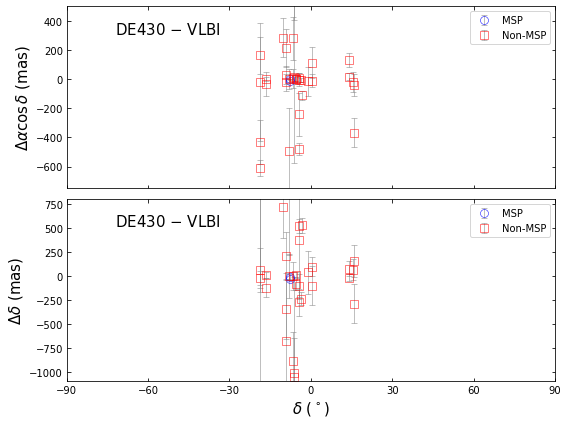

In [60]:
pos_oft_vs_coord(
    vlbi_timing430,
    [-750, 500, -1100, 800],
    vlbi_timing430["dra"],
    vlbi_timing430["ddec"],
    fig_name="vlbi_pos-oft-vs-dec-de430.eps",
    add_text=[0.1, 0.85, "DE430 $-$ VLBI"],
    ref="v",
    xaxis="dec",
    divided=True,
)

## 2.5 DE436 vs VLBI

In [61]:
mask = vlbi_timing["eph"] == "DE436"
vlbi_timing436 = vlbi_timing[mask]

nb_psr_436 = len(vlbi_timing436.group_by("psr_name").groups)
nb_obs_436 = len(vlbi_timing436)

print("We have", nb_psr_436,
      "pulsars in the sample from DE436 vs. PSRPI comparison with",
      nb_obs_436, "observations.")
# vlbi_timing436

We have 5 pulsars in the sample from DE436 vs. PSRPI comparison with 10 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


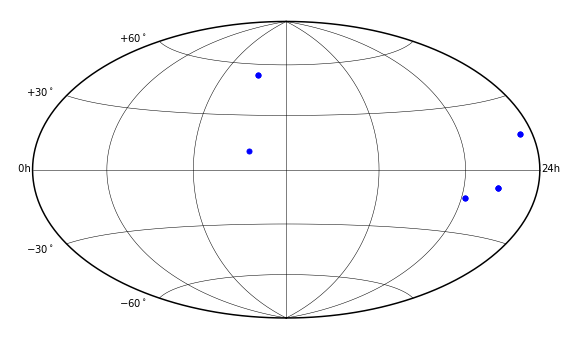

In [62]:
sou_dist_plot(vlbi_timing436["ra_v"], vlbi_timing436["dec_v"])
# ,
#               "../plots/vlbi_de436_psr.eps")

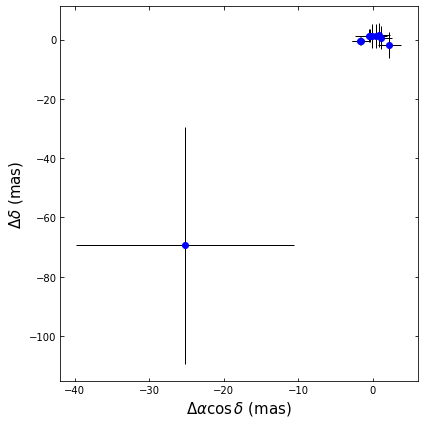

In [63]:
simple_plot(vlbi_timing436)

In [64]:
vlbi_timing436[vlbi_timing436["ddec"] < -60]

psr_bname,psr_name,pos_epoch,eph,ra_t,dec_t,pmra_t,pmdec_t,plx_t,ra_err_t,dec_err_t,pmra_err_t,pmdec_err_t,plx_err_t,ref,comment,pos_epoch_v,ra_v,dec_v,pmra_v,pmdec_v,plx_v,ra_err_v,dec_err_v,pmra_err_v,pmdec_err_v,plx_err_v,dra,ddec,dra_err,ddec_err
,,d,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas,mas / yr,mas / yr,mas,mas,mas,mas,mas
bytes10,str11,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J1022+1001,J1022+1001,55637.0,DE436,155.7416458333333,10.031302777777778,-19.0,-5.0,1.55,14.544886642182929,40.0,3.0,9.0,0.16,rsc+21,PPTA-DR2e,56000.0,155.74164875,10.0313236111,-14.89,5.59,1.39,1.477,2.0,0.05,0.03,0.04,-25.137758288459047,-69.44439531436669,14.61977173994174,40.04997988695946


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


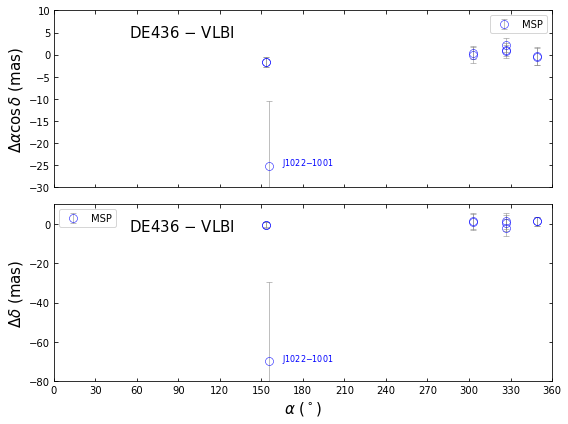

In [65]:
pos_oft_vs_coord(
    vlbi_timing436,
    [-30, 10, -80, 10],
    vlbi_timing436["dra"],
    vlbi_timing436["ddec"],
    fig_name="vlbi_pos-oft-vs-ra-de436.eps",
    add_text=[0.15, 0.85, "DE436 $-$ VLBI"],
    add_text_msp=[[165, -25, "J1022$-$1001", 0],
                 [165, -70, "J1022$-$1001", 1]],
    ref="v",
    xaxis="ra",
    divided=True,
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


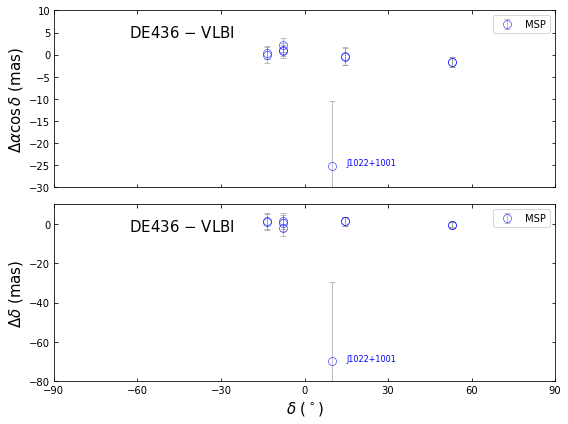

In [66]:
val_max = 80
pos_oft_vs_coord(
    vlbi_timing436,
    [-30, 10, -80, 10],
    vlbi_timing436["dra"],
    vlbi_timing436["ddec"],
    ref="v",
    xaxis="dec",
    fig_name="vlbi_pos-oft-vs-dec-de436.eps",
    add_text=[0.15, 0.85, "DE436 $-$ VLBI"],
    add_text_msp=[[15, -25, "J1022+1001", 0],
                 [15, -70, "J1022+1001", 1]],
    divided=True,
)

# 3. Comparison of timing and VLBI frames

## 3.1 Remove pulsars near ecliptic plane

We removed sources within $\pm~5^{\circ}$ around the ecliptic plane.

In [67]:
mask = (
    (vlbi_timing["psr_name"] != "J0614+2229")
    & (vlbi_timing["psr_name"] != "J0629+2415")
    #     & (vlbi_timing["psr_name"] != "J0826+2637")
    & (vlbi_timing["psr_name"] != "J1022+1001")
    & (vlbi_timing["psr_name"] != "J1257-1027")
    #     & (vlbi_timing["psr_name"] != "J1650-1654")
    & (vlbi_timing["psr_name"] != "J1703-1846")
    #     & (vlbi_timing["psr_name"] != "J2010-1323")
    #     & (vlbi_timing["psr_name"] != "J2145-0750")
    #     & (vlbi_timing["psr_name"] != "J2248-0101")
    & (vlbi_timing["psr_name"] != "J2346-0609")
)

vlbi_timing = Table(vlbi_timing[mask], masked=False)

Check what results we can get if we removing PSR J1012+5307.

In [68]:
# mask = (vlbi_timing["psr_name"] != "J1012+5307")

# vlbi_timing = Table(vlbi_timing[mask], masked=False)

In [69]:
mask = vlbi_timing["eph"] == "DE200"
vlbi_timing200 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE405"
vlbi_timing405 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE421"
vlbi_timing421 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE430"
vlbi_timing430 = vlbi_timing[mask]

mask = vlbi_timing["eph"] == "DE436"
vlbi_timing436 = vlbi_timing[mask]

## 3.1 DE200 vs VLBI

Do the LSQ fitting.

In [70]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    vlbi_timing200, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 55 1421119.0 1421115.8      -5.64     -10.42     -11.27 J0323+3944    48382 324010806.1
 2 55     19.4     15.6      -2.15     -14.66     -11.37 J0826+2637    51700   2674.4
 3 55      7.7      3.8      -2.87     -15.09     -11.47 J1537+1155    50300      0.2
 4 55      6.5      3.9      -2.91     -14.99     -11.31 J1537+1155    50261      0.5
 5 55      5.3      3.9      -3.22     -14.60     -10.89 J1537+1155    48778      1.7
 6 55      4.4      3.9      -5.89     -12.17      -9.09 J1901-0906    49901    121.2
 7 55      3.9      3.4      -5.90     -12.14      -8.95 J1820-0427    51700    113.7
 8 55      3.4      2.9      -5.47     -12.24      -9.35 J2113+4644    51700     86.9
 9 55      3.0      2.5      -5.06     -12.48      -9.66 J1321+8323    48383     58.4
10 55      2.7      2.2      -4.70     -12.35      -9.72 J0108+6608    48464     51.3
11 55      2.5      2.0      -4.63     -12.36    

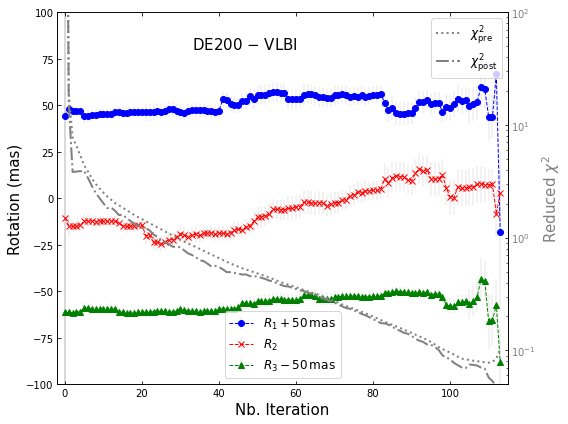

In [71]:
rot_vs_iter(
    pmt200,
    sig200,
    [-2, 115, -100, 100],
    #     fig_name="vlbi_orient-de200.eps",
    elw=0.1,
    add_text=[0.3, 0.9, "DE200 $-$ VLBI"],
    apr_chi2=apr_chi2_200,
    pst_chi2=pst_chi2_200,
    ax_loc="lower center",
    ax1_loc="upper right",
    ax1_ylim=[0.05, 100],
    caps=0, y_shift=50
)

In [72]:
rot200, iqr200 = find_pmt_est(pmt200)

# dra_200, ddec_200 = calc_dpos(vlbi_timing200, rot200, ref="v")

# a_chi2_200, p_chi2_200 = calc_chi2_4_fit(vlbi_timing200, dra_200, ddec_200)

Then I removed these seven outliers and re-fitted the data.

In [73]:
mask = (
    (np.fabs(vlbi_timing200["dra"]) < 1000)
    & (np.fabs(vlbi_timing200["ddec"]) < 1000)
)

vlbi_timing200_a = vlbi_timing200[mask]

In [74]:
nb_psr_200 = len(vlbi_timing200_a.group_by("psr_name").groups)
nb_obs_200 = len(vlbi_timing200_a)

print("After removing outliers, we have", nb_psr_200,
      "pulsars in the sample from DE200 vs. PSRPI comparison with",
      nb_obs_200, "observations.")

After removing outliers, we have 55 pulsars in the sample from DE200 vs. PSRPI comparison with 107 observations.


In [75]:
pmt200_a, sig200_a, indx, apr_chi2_200_a, pst_chi2_200_a = rot_fit_4_table(
    vlbi_timing200_a, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 55      7.3      3.2      -2.82     -15.06     -11.46 J1537+1155    50300      0.2
 2 55      6.0      3.2      -2.86     -14.96     -11.30 J1537+1155    50261      0.5
 3 55      4.8      3.2      -3.16     -14.58     -10.86 J1537+1155    48778      1.7
 4 55      3.7      3.2      -5.81     -12.12      -8.99 J1820-0427    51700    113.7
 5 55      3.2      2.7      -5.38     -12.23      -9.39 J2113+4644    51700     86.9
 6 55      2.8      2.3      -4.97     -12.46      -9.69 J1321+8323    48383     58.4
 7 55      2.5      2.0      -4.62     -12.33      -9.75 J2145-0750    48979     42.4
 8 55      2.3      1.8      -4.66     -12.26      -9.60 J2145-0750    50317      0.1
 9 55      2.2      1.8      -4.89     -12.36      -9.30 J1321+8323    48889     25.7
10 54      2.0      1.7      -3.75     -12.01      -9.65 J1917+1353    49763     32.7
11 54      1.9      1.6      -3.59     -13.09     -11.

100  7      0.1      0.1       9.64       7.80       6.46 J2046-0421    49021      0.2
101  6      0.1      0.1       8.93       7.36       5.76 J1623-0908    48715      0.1
102  5      0.1      0.1      -6.33       7.32     -16.19 J1543-0620    46918      0.1
103  5      0.1      0.1      -6.06       7.56     -15.51 J0040+5716    49667      0.0
104  4      0.1      0.0      17.05      -8.42      -7.21 J0157+6212    49709      0.0
105  3      0.1      0.0     -67.99       2.96     -38.22 J0323+3944    49290      0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


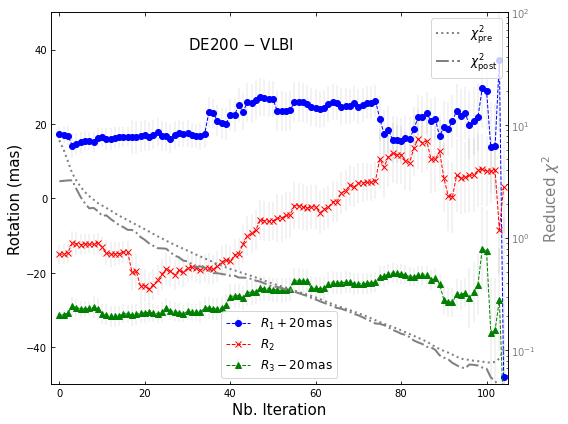

In [76]:
rot_vs_iter(
    pmt200_a,
    sig200_a,
    [-2, 105, -50, 50],
    fig_name="vlbi_orient-de200.eps",
    elw=0.1,
    add_text=[0.3, 0.9, "DE200 $-$ VLBI"],
    apr_chi2=apr_chi2_200_a,
    pst_chi2=pst_chi2_200_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    ax1_ylim=[0.05, 100],
    caps=0, y_shift=20
)

Determine the final estimates.

In [77]:
rot200_a, iqr200_a = find_pmt_est(pmt200_a)

dra_200, ddec_200 = calc_dpos(vlbi_timing200, rot200_a, ref="v")

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(vlbi_timing200, dra_200, ddec_200)

In [78]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200[0], iqr200[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200[1], iqr200[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200[2], iqr200[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[0], iqr200_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[1], iqr200_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot200_a[2], iqr200_a[2]))

Using all samples, the rotation parameters are
R1:       0 +/-      6 mas
R2:      -6 +/-      6 mas
R3:      -6 +/-      6 mas
After removing outliers, the rotation parameters are
R1:       1 +/-      6 mas
R2:      -5 +/-      6 mas
R3:      -6 +/-      6 mas


## 3.2 DE405 vs VLBI

In [79]:
pmt405, sig405, indx, apr_chi2_405, pst_chi2_405 = rot_fit_4_table(
    vlbi_timing405, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 11      0.5      0.4      -2.59       1.81       2.28 J1136+1551    52398      3.1
 2 10      0.3      0.2      -2.59       1.78       2.28 J0826+2637    52398      1.9
 3  9      0.2      0.1      -2.60       1.77       2.28 J2145-0750    53040      0.0
 4  9      0.2      0.1      -2.00       1.62       1.49 J1820-0427    52196      0.8
 5  8      0.1      0.1      -1.95       1.61       1.46 J1840+5640    52285      0.6
 6  7      0.1      0.1      -1.90       1.61       1.42 J1012+5307    50700      0.0
 7  6      0.1      0.0     -18.25       9.78       3.83 J0332+5434    52337      0.0
 8  5      0.1      0.0      -1.06      -1.58       1.00 J2145-0750    53070      0.0
 9  4      0.1      0.1       9.46       4.91      41.58 J1917+1353    52298      0.1
10  3      0.1      0.0     -45.87       3.46       3.56 J2113+4644    52284      0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


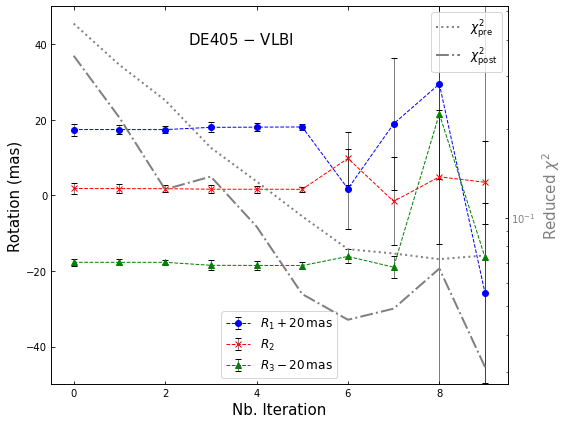

In [80]:
rot_vs_iter(
    pmt405,
    sig405,
    [-0.5, 9.5, -50, 50],
    fig_name="vlbi_orient-de405.eps",
    elw=0.5,
    add_text=[0.3, 0.9, "DE405 $-$ VLBI"],
    apr_chi2=apr_chi2_405,
    pst_chi2=pst_chi2_405,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=20
)

In [81]:
rot405, iqr405 = find_pmt_est(pmt405)

dra_405, ddec_405 = calc_dpos(vlbi_timing405, rot405, ref="v")

a_chi2_405, p_chi2_405 = calc_chi2_4_fit(vlbi_timing405, dra_405, ddec_405)

## 3.3 DE421 vs VLBI

In [82]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
    vlbi_timing421, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 21      7.6      7.5      -1.06      -0.81      -0.22 J1645-0317    56000    280.3
 2 20      3.0      2.9      -1.31      -0.74      -0.18 J0729-1836    56000     76.5
 3 19      1.8      1.7      -1.24      -0.74      -0.22 J2149+6329    54595     24.5
 4 18      1.4      1.3      -1.01      -0.86      -0.33 J0157+6212    56000     20.2
 5 18      1.0      0.9      -1.02      -0.86      -0.33 J1937+2544    54248      8.5
 6 17      0.9      0.8      -0.97      -0.79      -0.29 J0335+4555    54596      8.2
 7 16      0.8      0.7      -0.85      -0.71      -0.36 J2354+6155    56000      7.9
 8 15      0.6      0.5      -0.89      -0.71      -0.35 J1543-0620    54601      4.8
 9 15      0.5      0.4      -0.92      -0.71      -0.32 J2145-0750    54903      5.1
10 15      0.5      0.3      -0.93      -0.83      -0.55 J1537+1155    52077      2.5
11 14      0.4      0.3      -1.89      -0.19      -0.

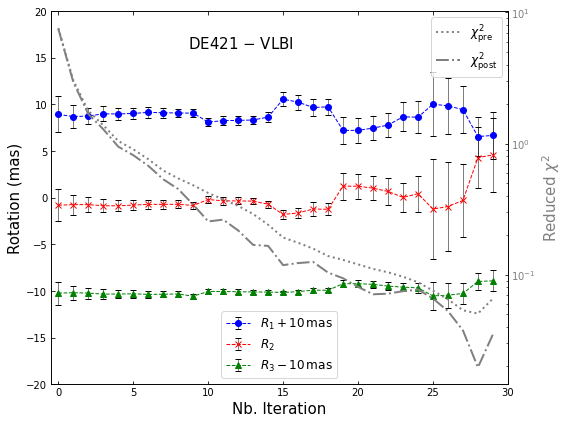

In [83]:
rot_vs_iter(
    pmt421,
    sig421,
    [-0.5, 30, -20, 20],
    #     fig_name="vlbi_orient-de421.eps",
    elw=0.5,
    add_text=[0.3, 0.9, "DE421 $-$ VLBI"],
    apr_chi2=apr_chi2_421,
    pst_chi2=pst_chi2_421,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=10
)

In [84]:
rot421, iqr421 = find_pmt_est(pmt421)

Removed the outlier and refitted.

In [85]:
mask = (
    (np.fabs(vlbi_timing421["dra"]) < 1000)
    & (np.fabs(vlbi_timing421["ddec"]) < 1000)
)

vlbi_timing421_a = vlbi_timing421[mask]

In [86]:
nb_psr_421 = len(vlbi_timing421_a.group_by("psr_name").groups)
nb_obs_421 = len(vlbi_timing421_a)

print("When removing the outlier, we have", nb_psr_421,
      "pulsars in the sample from DE421 vs. PSRPI comparison with",
      nb_obs_421, "observations.")
# vlbi_timing421_a

When removing the outlier, we have 21 pulsars in the sample from DE421 vs. PSRPI comparison with 31 observations.


In [87]:
pmt421_a, sig421_a, indx, apr_chi2_421_a, pst_chi2_421_a = rot_fit_4_table(
    vlbi_timing421_a, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 21      7.5      7.4      -1.07      -0.81      -0.22 J1645-0317    56000    280.3
 2 20      2.8      2.7      -1.31      -0.74      -0.18 J0729-1836    56000     76.5
 3 19      1.5      1.4      -1.25      -0.74      -0.22 J2149+6329    54595     24.5
 4 18      1.0      0.9      -1.02      -0.86      -0.33 J1937+2544    54248      8.5
 5 17      0.9      0.8      -0.97      -0.79      -0.29 J0335+4555    54596      8.2
 6 16      0.8      0.7      -0.85      -0.71      -0.36 J2354+6155    56000      7.9
 7 15      0.6      0.5      -0.89      -0.71      -0.35 J1543-0620    54601      4.8
 8 15      0.5      0.4      -0.92      -0.71      -0.32 J2145-0750    54903      5.1
 9 15      0.5      0.3      -0.93      -0.83      -0.55 J1537+1155    52077      2.5
10 14      0.4      0.3      -1.89      -0.19      -0.04 J1012+5307    55000      0.1
11 14      0.4      0.3      -1.74      -0.33      -0.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


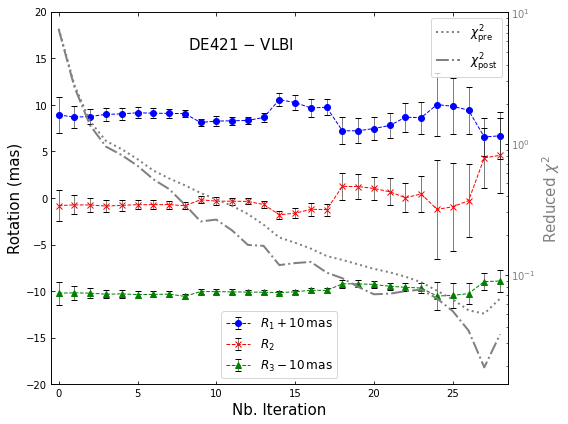

In [88]:
rot_vs_iter(
    pmt421_a,
    sig421_a,
    [-0.5, 28.5, -20, 20],
    xaxis_range=np.arange(0, 26, 5),
    fig_name="vlbi_orient-de421.eps",
    elw=0.5,
    add_text=[0.3, 0.9, "DE421 $-$ VLBI"],
    apr_chi2=apr_chi2_421_a,
    pst_chi2=pst_chi2_421_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=10
)

In [89]:
rot421_a, iqr421_a = find_pmt_est(pmt421_a)

dra_421, ddec_421 = calc_dpos(vlbi_timing421, rot421_a, ref="v")

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(vlbi_timing421, dra_421, ddec_421)

In [90]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot421[0], iqr421[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot421[1], iqr421[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot421[2], iqr421[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot421_a[0], iqr421_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot421_a[1], iqr421_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot421_a[2], iqr421_a[2]))

Using all samples, the rotation parameters are
R1:      -1 +/-      1 mas
R2:      -1 +/-      0 mas
R3:      -0 +/-      0 mas
After removing outliers, the rotation parameters are
R1:      -1 +/-      1 mas
R2:      -1 +/-      0 mas
R3:      -0 +/-      0 mas


## 3.4 DE430 vs VLBI

In [91]:
pmt430, sig430, indx, apr_chi2_430, pst_chi2_430 = rot_fit_4_table(
    vlbi_timing430, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 18     15.3     14.9      -3.88      37.84      -2.73 J1833-0338    57600    388.3
 2 18      8.7      8.3      -6.75      39.28      -3.50 J0729-1836    57600    131.9
 3 18      6.5      6.0     -25.39      55.78       0.94 J1820-0427    57600    124.7
 4 18      4.3      3.7     -33.18      59.60       4.06 J1645-0317    57600     49.5
 5 17      3.3      2.8     -16.59      48.22       2.80 J1820-0427    57600     53.3
 6 16      2.2      1.7       8.16      34.85      -0.57 J2145-0750    57600      0.2
 7 16      1.8      1.8       2.06      23.40      -2.70 J1136+1551    57600     16.5
 8 16      1.5      1.5       4.36      25.82      -1.52 J0151-0635    57600     12.0
 9 16      1.3      1.3       6.07      20.94      -1.98 J1833-0338    57600     10.7
10 15      1.0      1.0      -8.20      19.14      -0.25 J0729-1836    57600      8.4
11 14      0.9      0.8      -9.93      21.73       0.

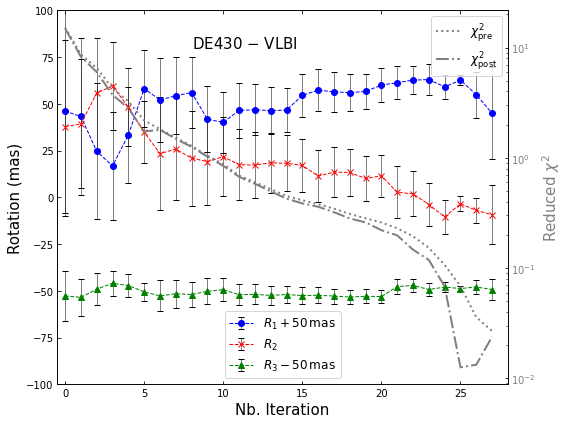

In [92]:
rot_vs_iter(
    pmt430,
    sig430,
    [-0.5, 28, -100, 100],
    #     fig_name="vlbi_orient-de430.eps",
    elw=0.5,
    add_text=[0.3, 0.9, "DE430 $-$ VLBI"],
    apr_chi2=apr_chi2_430,
    pst_chi2=pst_chi2_430,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=50
)

In [93]:
rot430, iqr430 = find_pmt_est(pmt430)

Remove the outliers and refitted.

In [94]:
mask = (
    (np.fabs(vlbi_timing430["dra"]) < 1000)
    & (np.fabs(vlbi_timing430["ddec"]) < 1000)
)

vlbi_timing430_a = vlbi_timing430[mask]

In [95]:
nb_psr_430 = len(vlbi_timing430_a.group_by("psr_name").groups)
nb_obs_430 = len(vlbi_timing430_a)

print("When removing the outlier, we have", nb_psr_430,
      "pulsars in the sample from DE430 vs. PSRPI comparison with",
      nb_obs_430, "observations.")
# vlbi_timing430_a

When removing the outlier, we have 18 pulsars in the sample from DE430 vs. PSRPI comparison with 28 observations.


In [96]:
pmt430_a, sig430_a, indx, apr_chi2_430_a, pst_chi2_430_a = rot_fit_4_table(
    vlbi_timing430_a, ref="v"
)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 18      8.9      8.5      -6.58      39.21      -3.48 J0729-1836    57600    131.9
 2 18      6.7      6.2     -25.23      55.70       0.96 J1820-0427    57600    124.7
 3 18      4.4      3.8     -33.01      59.53       4.08 J1645-0317    57600     49.5
 4 17      3.3      2.9     -16.42      48.14       2.83 J1820-0427    57600     53.3
 5 16      2.2      1.7       8.34      34.77      -0.55 J2145-0750    57600      0.2
 6 16      1.8      1.8       2.40      23.24      -2.51 J1136+1551    57600     16.5
 7 16      1.5      1.5       4.69      25.65      -1.33 J0151-0635    57600     12.0
 8 16      1.2      1.2       6.41      20.77      -1.78 J1833-0338    57600     10.7
 9 15      1.0      1.0      -7.86      18.92      -0.01 J0729-1836    57600      8.4
10 14      0.8      0.8      -9.59      21.51       0.82 J1917+1353    57600      7.3
11 13      0.6      0.6      -3.15      17.26      -1.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


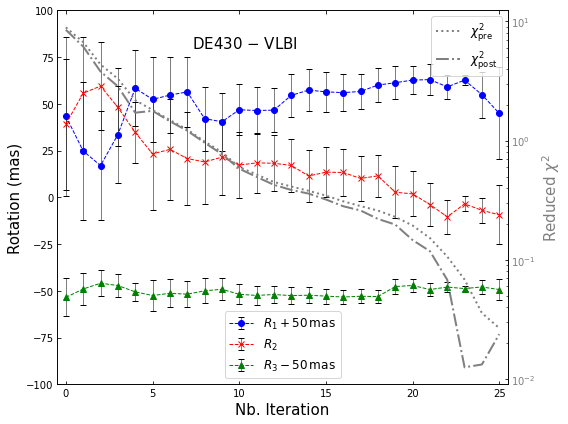

In [97]:
rot_vs_iter(
    pmt430_a,
    sig430_a,
    [-0.5, 25.5, -100, 100],
    fig_name="vlbi_orient-de430.eps",
    elw=0.5,
    add_text=[0.3, 0.9, "DE430 $-$ VLBI"],
    apr_chi2=apr_chi2_430_a,
    pst_chi2=pst_chi2_430_a,
    ax_loc="lower center",
    ax1_loc="upper right",
    y_shift=50
)

In [98]:
rot430_a, iqr430_a = find_pmt_est(pmt430_a)

dra_430, ddec_430 = calc_dpos(vlbi_timing430, rot430_a, ref="v")

a_chi2_430, p_chi2_430 = calc_chi2_4_fit(vlbi_timing430, dra_430, ddec_430)

In [99]:
print("Using all samples, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot430[0], iqr430[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot430[1], iqr430[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot430[2], iqr430[2]))

print("After removing outliers, the rotation parameters are")
print("R1:  {:6.0f} +/- {:6.0f} mas".format(rot430_a[0], iqr430_a[0]))
print("R2:  {:6.0f} +/- {:6.0f} mas".format(rot430_a[1], iqr430_a[2]))
print("R3:  {:6.0f} +/- {:6.0f} mas".format(rot430_a[2], iqr430_a[2]))

Using all samples, the rotation parameters are
R1:       4 +/-      9 mas
R2:      17 +/-      3 mas
R3:      -2 +/-      3 mas
After removing outliers, the rotation parameters are
R1:       5 +/-      9 mas
R2:      17 +/-      3 mas
R3:      -1 +/-      3 mas


## 3.5 DE436 vs VLBI

The number of pulsars is too small for determing the orientation offset.

In [100]:
nb_psr_436 = len(vlbi_timing436.group_by("psr_name").groups)
nb_obs_436 = len(vlbi_timing436)

print("When removing the outlier, we have", nb_psr_436,
      "pulsars in the sample from DE436 vs. PSRPI comparison with",
      nb_obs_436, "observations.")

When removing the outlier, we have 4 pulsars in the sample from DE436 vs. PSRPI comparison with 9 observations.


In [101]:
rot436, iqr436, dra_436, ddec_436, a_chi2_436, p_chi2_436 = simple_rot_fit_4_table(
    vlbi_timing436, ref="v"
)

[msg] There are 9 timing solutions for 4 pulsars
[msg] Before removing outliers, the reduced chi-squared is 0.52.
[msg] There is no outliers.
[info] NO.Obs  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  R1_err  R2_err R3_err
[info] Unit: mas
[info]  9  4      0.5      0.3      -2.13       0.27       0.65       0.54       0.45       0.36


# 4 Summary

In [102]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_v", "dec_err_v", "pos_err_v"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and VLBI positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"],
)

print(tbl)

Positional formal uncertainty for timing and VLBI positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_v dec_err_v pos_err_v
---------------------------------------------------------------
DE200    58.70    120.00    145.46     1.44      1.00      1.77
DE405   474.54    130.00    495.34     1.45      1.00      1.76
DE421    12.24     35.00     37.51     1.44      1.00      1.76
DE430    70.14    184.64    204.20     1.50      2.00      2.50
DE436     0.09      0.24      0.26     1.46      3.00      3.37
---------------------------------------------------------------


A short table to summarize the orientation between DE frame and Gaia frame.

In [103]:
mydata = [
    [
        nb_psr_200,
        nb_obs_200,
        rot200_a[0],
        iqr200_a[0],
        rot200_a[1],
        iqr200_a[1],
        rot200_a[2],
        iqr200_a[2],
        a_chi2_200,
        p_chi2_200,
    ],
    [
        nb_psr_405,
        nb_obs_405,
        rot405[0],
        iqr405[0],
        rot405[1],
        iqr405[1],
        rot405[2],
        iqr405[2],
        a_chi2_405,
        p_chi2_405,
    ],
    [
        nb_psr_421,
        nb_obs_421,
        rot421_a[0],
        iqr421_a[0],
        rot421_a[1],
        iqr421_a[1],
        rot421_a[2],
        iqr421_a[2],
        a_chi2_421,
        p_chi2_421,
    ],
    [
        nb_psr_430,
        nb_obs_430,
        rot430_a[0],
        iqr430_a[0],
        rot430_a[1],
        iqr430_a[1],
        rot430_a[2],
        iqr430_a[2],
        a_chi2_430,
        p_chi2_430,
    ],
        [
            nb_psr_436,
            nb_obs_436,
            rot436[0],
            iqr436[0],
            rot436[1],
            iqr436[1],
            rot436[2],
            iqr436[2],
            a_chi2_436,
            p_chi2_436,
        ],
]

myheaders = [
    "Nb.PSR",
    "Nb.Obs",
    "R1",
    "R1_err",
    "R2",
    "R2_err",
    "R3",
    "R3_err",
    "ApreFitChi2",
    "PostFitChi2",
]
# mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. VLBI frame (mas)",
    data_fmts=[
        "%d",
        "%d",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.2f",
        "%6.2f",
    ],
)

print(tbl)

                    Orientation of DE frame wrt. VLBI frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200     55    107    0.7    5.9   -5.4   14.7   -6.0    5.7  1402662.94  1402660.63
DE405     12     14   -2.3    0.5    1.8    1.1    2.3    1.3        0.39        0.31
DE421     21     31   -1.2    0.7   -0.7    0.6   -0.1    0.5        7.23        7.16
DE430     18     28    4.8    9.5   17.2   13.5   -0.9    2.7       14.48       14.23
DE436      4      9   -2.1    0.5    0.3    0.5    0.7    0.4        0.52        0.31
-------------------------------------------------------------------------------------
